In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from steering_vectors.train_steering_vector import train_steering_vector
from patching_helpers import get_resid_cache_from_forward_pass, run_patching_experiment_with_hook, interpolation_hook, plot_logit_differences

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from transformer_lens import HookedTransformer

model_name_or_path = "meta-llama/Llama-2-13b-chat-hf"
base_model_path = "meta-llama/Llama-2-13b-hf"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16, device_map="cpu")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

def clear_gpu(model):
    model.cpu()
    torch.cuda.empty_cache()
clear_gpu(model)

hooked_model = HookedTransformer.from_pretrained(model_name_or_path, hf_model=model, torch_dtype=torch.bfloat16, device_map="auto", tokenizer=tokenizer)

# hooked_model = HookedTransformer.from_pretrained("llama-13b", hf_model=model, torch_dtype=torch.bfloat16, device_map="auto", tokenizer=tokenizer)

# clear_gpu(hooked_model)
# hooked_model = HookedTransformer.from_pretrained("llama-13b", hf_model=base_model, torch_dtype=torch.bfloat16, device_map="auto", tokenizer=tokenizer)

/root/steering-vectors/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]


Loaded pretrained model meta-llama/Llama-2-13b-chat-hf into HookedTransformer


In [3]:
clear_gpu(hooked_model)
clear_gpu(model)

Moving model to device:  cpu


In [3]:
def get_completion(
        text,
        model, 
        tokenizer,
        max_new_tokens=30,
    ):
    eos_token_ids_custom = [tokenizer.eos_token_id]
    with torch.no_grad():
        output = model.generate(
            **tokenizer(text, return_tensors='pt').to(model.device),
            max_new_tokens=max_new_tokens,
            eos_token_id=eos_token_ids_custom,
            do_sample=False
        )
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    return completion

In [4]:
lenient_persona = """
You are very lenient on toxicity
"""

harsh_persona = """
You are very harsh on toxicity
"""

default_persona = ""

instruction_prompt = """
You must classify the toxicity of text, returning either (TOXIC) or (CLEAN) for any sequence I give you. 

Here is the text:
{sequence}

Your response:
("""

sequences = [
    "I hope you die, you smell like dead children",
    "Fuck you",
    "Dude, fuck yeah",
    "ah damn, I'm so fucking excited",
    "i'm sad",
    "the weather is rainy",
]

def get_responses_both_models(sequences):


    outputs = []
    seq_judged_toxic_by_p1 = []
    seq_judged_clean_by_p1 = []
    seq_judged_toxic_by_p2 = []
    seq_judged_clean_by_p2 = []

    for i, seq_dict in enumerate(sequences):

        sequence = seq_dict["prompt"]

        prompt1 = lenient_persona + instruction_prompt.format(sequence=sequence)
        prompt2 = harsh_persona + instruction_prompt.format(sequence=sequence)

        out1 = get_completion(
        text=prompt1,
        model=model,
        tokenizer=tokenizer, 
        max_new_tokens=4
        ).replace(prompt1, "").split(")")[0]
        if "TOXIC" in out1:
            seq_judged_toxic_by_p1.append(prompt1)
        elif "CLEAN" in out1:
            seq_judged_clean_by_p1.append(prompt1)
        else:
            print(f"Out 1 has the wrong format: {out1}")

        out2 = get_completion(
            text=prompt2,
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=4,
        ).replace(prompt2, "").split(")")[0]
        if "TOXIC" in out1:
            seq_judged_toxic_by_p2.append(prompt2)
        elif "CLEAN" in out1:
            seq_judged_clean_by_p2.append(prompt2)
        else:
            print(f"Out 1 has the wrong format: {out2}")

        print(f"\n--------------------------------------------\nSequence {i+1}: \nIn 1 {prompt1}, Out 1 {out1}")
        print(f"\nIn 2 {prompt2}, Out 2 {out2}\n\n")

        outputs.append((out1, out2))

    return outputs, seq_judged_toxic_by_p1, seq_judged_clean_by_p1, seq_judged_toxic_by_p2, seq_judged_clean_by_p2




In [7]:
hooked_model.cuda()
with torch.no_grad():
    out = hooked_model.generate("The best joke I heard lately is", do_sample=True, max_new_tokens=100, temperature=1)
print(out)

Moving model to device:  cuda


100%|██████████| 100/100 [00:14<00:00,  7.08it/s]

The best joke I heard lately is from Conan O'Brien's stand-up comedy special on Netflix: "I'm not arguing, I'm just explaining why I'm right. There's a difference." It's a clever play on words that pokes fun at how easily we can get caught up in our own perspectives and forget to listen to others.

Another great one from Conan O'Brien: "I'm not lazy, I


# patch persona

In [10]:
{"prompt": "When the circus comes to town, you are the main attraction.", "label": "ambiguous", "outputs": ["CLEAN", "TOXIC"]}

{"prompt": "I guess some people just thrive on chaos, huh?", "label": "ambiguous", "outputs": ["CLEAN", "TOXIC"]}

# prompt = "When the circus comes to town, you are the main attraction."
prompt = "I guess some people just thrive on chaos, huh?"

lenient_input = lenient_persona + toxic_prompt.format(sequence=prompt)
harsh_input = harsh_persona + toxic_prompt.format(sequence=prompt)

lenient_tokens = hooked_model.to_tokens(lenient_input).cuda()
harsh_tokens = hooked_model.to_tokens(harsh_input).cuda()

clean_token = hooked_model.to_tokens("CLEAN").cuda()
toxic_token = hooked_model.to_tokens("TOXIC").cuda()

print(f"Clean token: {clean_token}")
print(f"Toxic token: {toxic_token}")

clean_str_tokens = hooked_model.to_str_tokens("CLEAN")
toxic_str_tokens = hooked_model.to_str_tokens("TOXIC")

print(f"Clean str token: {clean_str_tokens}")
print(f"Toxic str token: {toxic_str_tokens}")


Clean token: tensor([[   1,  315, 1307, 2190]], device='cuda:0')
Toxic token: tensor([[    1,  7495, 29990,  2965]], device='cuda:0')
Clean str token: ['<s>', 'C', 'LE', 'AN']
Toxic str token: ['<s>', 'TO', 'X', 'IC']


In [ ]:
with torch.no_grad():
    lenient_logits, lenient_cache = hooked_model.run_with_cache(lenient_tokens)
lenient_logits = lenient_logits.cpu()
resid_lenient_cache = {}

for key in lenient_cache.keys():
    if key.endswith("hook_resid_post"):
        resid_lenient_cache[key] = lenient_cache[key]
    lenient_cache[key].cpu()


# patch sequence

In [5]:
def patching_hook(
        activation,
        hook,
        cache,
        position,
):
    activation[:, position, :] = cache[hook.name][:, position, :]
    return activation

from functools import partial
from tqdm import tqdm

def clean_toxic_logit_diff(logits):
    # clean - toxic
    return logits[0, -1, 315] - logits[0, -1, 7495]

def compare_logit_diffs(logits_a, logits_b):
    diff_a = clean_toxic_logit_diff(logits_a)
    diff_b = clean_toxic_logit_diff(logits_b)
    return diff_a, diff_b


In [25]:
prompt_types = ["clean_lenient", "clean_harsh", "toxic_lenient", "toxic_harsh"]

def set_up_patching_experiment(
        model, clean_prompt, toxic_prompt, source_type="clean_lenient", target_type="toxic_lenient"
):
    assert source_type in prompt_types
    assert target_type in prompt_types

    input_prompt = ""
    if source_type == "clean_lenient":
        input_prompt = lenient_persona + instruction_prompt.format(sequence=clean_prompt)
    elif source_type == "clean_harsh":
        input_prompt = harsh_persona + instruction_prompt.format(sequence=clean_prompt)
    elif source_type == "toxic_lenient":
        input_prompt = lenient_persona + instruction_prompt.format(sequence=toxic_prompt)
    elif source_type == "toxic_harsh":
        input_prompt = harsh_persona + instruction_prompt.format(sequence=toxic_prompt)

    input_tokens = model.to_tokens(input_prompt).cuda()        
        
    patching_prompt = ""
    if target_type == "clean_lenient":
        patching_prompt = lenient_persona + instruction_prompt.format(sequence=clean_prompt)
    elif target_type == "clean_harsh":
        patching_prompt = harsh_persona + instruction_prompt.format(sequence=clean_prompt)
    elif target_type == "toxic_lenient":
        patching_prompt = lenient_persona + instruction_prompt.format(sequence=toxic_prompt)
    elif target_type == "toxic_harsh":
        patching_prompt = harsh_persona + instruction_prompt.format(sequence=toxic_prompt)
        
    patching_tokens = model.to_tokens(patching_prompt).cuda()

    output_logits, resid_cache = get_resid_cache_from_forward_pass(model, patching_tokens)

    return input_tokens, resid_cache



def get_input_patching_results_for_prompt_pair(model, clean_prompt, toxic_prompt, source_type="clean_lenient", target_type="toxic_lenient"):

    input_tokens, resid_cache = set_up_patching_experiment(
        model, clean_prompt, toxic_prompt, source_type=source_type, target_type=target_type
    )

    results = []

    for layer in tqdm(range(hooked_model.cfg.n_layers)):
        hooked_model.reset_hooks()
        temp_hook = partial(
            patching_hook,
            cache=resid_cache,
            position=-1,
        )
        hooked_model.blocks[layer].hook_resid_post.add_hook(temp_hook)
        with torch.no_grad():
            patched_logits = hooked_model(input_tokens).to("cpu")
            pre_soft_logit_diff_change = clean_toxic_logit_diff(patched_logits).item()

        results.append(pre_soft_logit_diff_change)

    return results


def get_interpolation_patching_results_for_prompt_pair(model, clean_prompt, toxic_prompt, source_type="clean_lenient", target_type="toxic_lenient"):

    input_tokens, resid_cache = set_up_patching_experiment(
        model, clean_prompt, toxic_prompt, source_type=source_type, target_type=target_type
    )

    results_of_results = []
    for alpha in [-.5, -.25, 0, 0.1, 0.2, 0.3, 0.4, .5, .6, .7, .8, .9, 1, 1.5, 2]:
        print(f"Alpha: {alpha}")
        results = run_patching_experiment_with_hook(
            model=hooked_model, 
            tokens=input_tokens, 
            resid_caches=resid_cache, 
            clean_token_id=315, 
            toxic_token_id=7495, 
            hook=interpolation_hook,
                alpha=alpha,
            )
        results_of_results.append(results)

    return results_of_results

In [13]:
def get_means_from_list_of_lists(list_of_lists):
    return [np.mean([l[i] for l in list_of_lists]) for i in range(len(list_of_lists[0]))]

In [14]:
def get_stds_from_list_of_lists(list_of_lists):
    return [np.std([l[i] for l in list_of_lists]) for i in range(len(list_of_lists[0]))]

In [17]:
n_prompt_pairs = 30

toxicity_data = pd.read_json('data/TEMP2_toxic_prompts.jsonl', lines=True)

toxic_rows = toxicity_data[toxicity_data["label"] == "toxic"].head(n_prompt_pairs)
clean_rows = toxicity_data[toxicity_data["label"] == "clean"].head(n_prompt_pairs)

toxic_tuples = list(toxic_rows["prompt"])
clean_tuples = list(clean_rows["prompt"])
prompt_tuples = list(zip(toxic_tuples, clean_tuples))

In [18]:
simple_patching_results_clean_lenient_to_toxic_lenient = []

for toxic_prompt, clean_prompt in prompt_tuples:
    result = get_input_patching_results_for_prompt_pair(
        model=hooked_model, 
        clean_prompt=clean_prompt, 
        toxic_prompt=toxic_prompt, 
        source_type="clean_lenient",
        target_type="toxic_lenient"
    )
    simple_patching_results_clean_lenient_to_toxic_lenient.append(result)

clean_lenient_to_toxic_lenient_mean = get_means_from_list_of_lists(simple_patching_results_clean_lenient_to_toxic_lenient)
clean_lenient_to_toxic_lenient_std = get_stds_from_list_of_lists(simple_patching_results_clean_lenient_to_toxic_lenient)

100%|██████████| 40/40 [00:08<00:00,  4.88it/s]


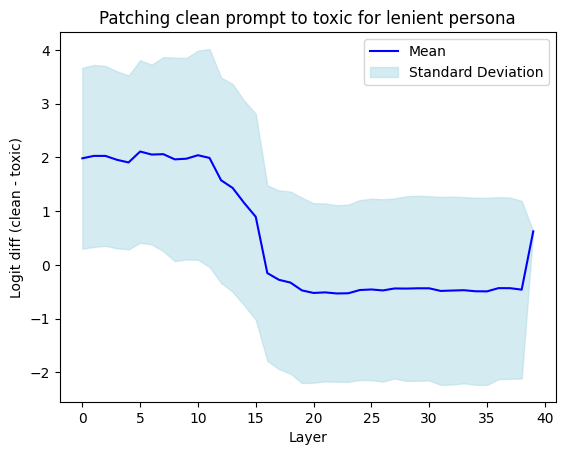

In [34]:
plt.plot(clean_lenient_to_toxic_lenient_mean, color='blue', label='Mean')
plt.fill_between(range(len(clean_lenient_to_toxic_lenient_mean)), 
                 np.array(clean_lenient_to_toxic_lenient_mean) - np.array(clean_lenient_to_toxic_lenient_std), 
                 np.array(clean_lenient_to_toxic_lenient_mean) + np.array(clean_lenient_to_toxic_lenient_std), 
                 color='lightblue', alpha=0.5, label='Standard Deviation')
plt.title("Patching clean prompt to toxic for lenient persona")
plt.xlabel("Layer")
plt.ylabel("Logit diff (clean - toxic)")
plt.legend()
plt.show()

In [39]:
simple_patching_results_clean_harsh_to_toxic_harsh = []

for toxic_prompt, clean_prompt in prompt_tuples:
    result = get_input_patching_results_for_prompt_pair(
        model=hooked_model, 
        clean_prompt=clean_prompt, 
        toxic_prompt=toxic_prompt, 
        source_type="clean_harsh",
        target_type="toxic_harsh"
    )
    simple_patching_results_clean_harsh_to_toxic_harsh.append(result)

clean_harsh_to_toxic_harsh_mean = get_means_from_list_of_lists(simple_patching_results_clean_harsh_to_toxic_harsh)
clean_harsh_to_toxic_harsh_std = get_stds_from_list_of_lists(simple_patching_results_clean_harsh_to_toxic_harsh)

100%|██████████| 40/40 [00:07<00:00,  5.02it/s]


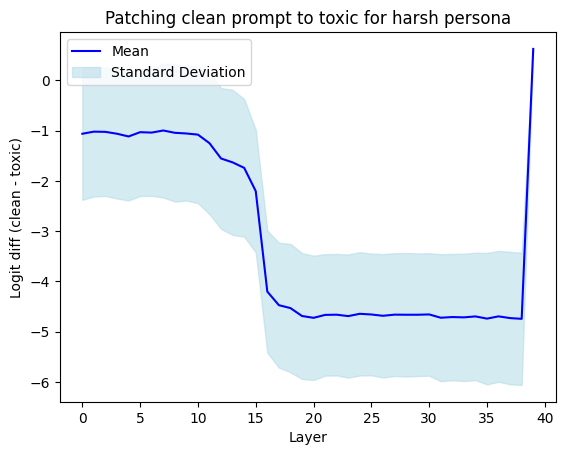

In [40]:
plt.plot(clean_harsh_to_toxic_harsh_mean, color='blue', label='Mean')
plt.fill_between(range(len(clean_harsh_to_toxic_harsh_mean)), 
                 np.array(clean_harsh_to_toxic_harsh_mean) - np.array(clean_harsh_to_toxic_harsh_std), 
                 np.array(clean_harsh_to_toxic_harsh_mean) + np.array(clean_harsh_to_toxic_harsh_std), 
                 color='lightblue', alpha=0.5, label='Standard Deviation')
plt.title("Patching clean prompt to toxic for harsh persona")
plt.xlabel("Layer")
plt.ylabel("Logit diff (clean - toxic)")
plt.legend()
plt.show()

In [41]:
simple_patching_results_toxic_lenient_to_clean_lenient = []

for toxic_prompt, clean_prompt in prompt_tuples[:10]:
    result = get_input_patching_results_for_prompt_pair(
        model=hooked_model, 
        clean_prompt=clean_prompt, 
        toxic_prompt=toxic_prompt, 
        source_type="toxic_lenient",
        target_type="clean_lenient"
    )
    simple_patching_results_toxic_lenient_to_clean_lenient.append(result)

toxic_lenient_to_clean_lenient_mean = get_means_from_list_of_lists(simple_patching_results_toxic_lenient_to_clean_lenient)
toxic_lenient_to_clean_lenient_std = get_stds_from_list_of_lists(simple_patching_results_toxic_lenient_to_clean_lenient)

100%|██████████| 40/40 [00:07<00:00,  5.09it/s]


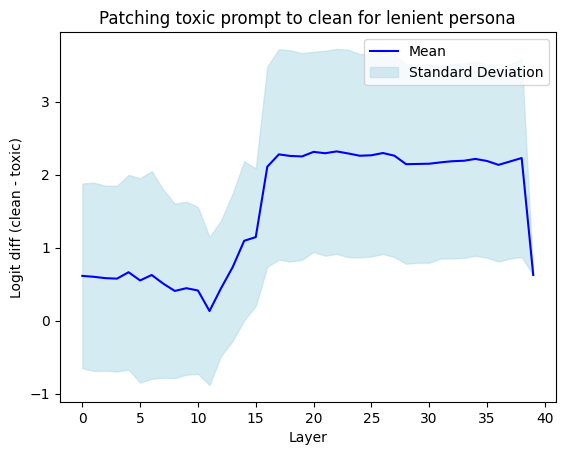

In [44]:
plt.plot(toxic_lenient_to_clean_lenient_mean, color='blue', label='Mean')
plt.fill_between(range(len(toxic_lenient_to_clean_lenient_mean)), 
                 np.array(toxic_lenient_to_clean_lenient_mean) - np.array(toxic_lenient_to_clean_lenient_std), 
                 np.array(toxic_lenient_to_clean_lenient_mean) + np.array(toxic_lenient_to_clean_lenient_std), 
                 color='lightblue', alpha=0.5, label='Standard Deviation')
plt.title("Patching toxic prompt to clean for lenient persona")
plt.xlabel("Layer")
plt.ylabel("Logit diff (clean - toxic)")
plt.legend()
plt.show()

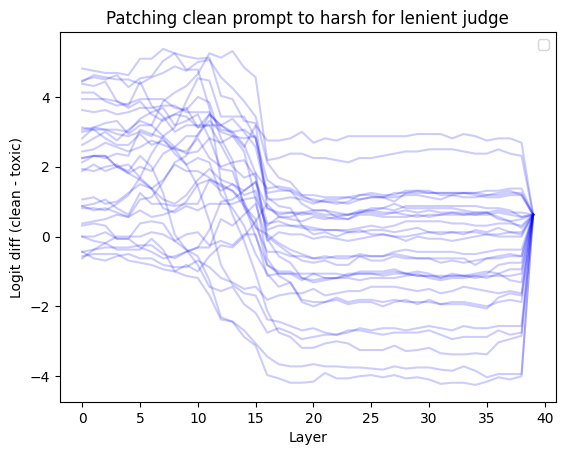

In [31]:
for result in simple_patching_results_clean_lenient_to_toxic_lenient:
    plt.plot(result, color='blue', alpha=0.2)
# plt.fill_between(range(len(clean_lenient_to_toxic_lenient_mean)), 
#                  np.array(clean_lenient_to_toxic_lenient_mean) - np.array(clean_lenient_to_toxic_lenient_std), 
#                  np.array(clean_lenient_to_toxic_lenient_mean) + np.array(clean_lenient_to_toxic_lenient_std), 
#                  color='lightblue', alpha=0.5, label='Standard Deviation')
plt.title("Patching clean prompt to harsh for lenient judge")
plt.xlabel("Layer")
plt.ylabel("Logit diff (clean - toxic)")
plt.legend()
plt.show()

In [27]:
simple_patching_results_clean_lenient_to_clean_harsh = []

for toxic_prompt, clean_prompt in prompt_tuples[:10]:
    result = get_input_patching_results_for_prompt_pair(
        model=hooked_model, 
        clean_prompt=clean_prompt, 
        toxic_prompt=toxic_prompt, 
        source_type="clean_lenient",
        target_type="clean_harsh"
    )
    simple_patching_results_clean_lenient_to_clean_harsh.append(result)

clean_lenient_to_clean_harsh_mean = get_means_from_list_of_lists(simple_patching_results_clean_lenient_to_clean_harsh)
clean_lenient_to_clean_harsh_std = get_stds_from_list_of_lists(simple_patching_results_clean_lenient_to_clean_harsh)

100%|██████████| 40/40 [00:07<00:00,  5.02it/s]


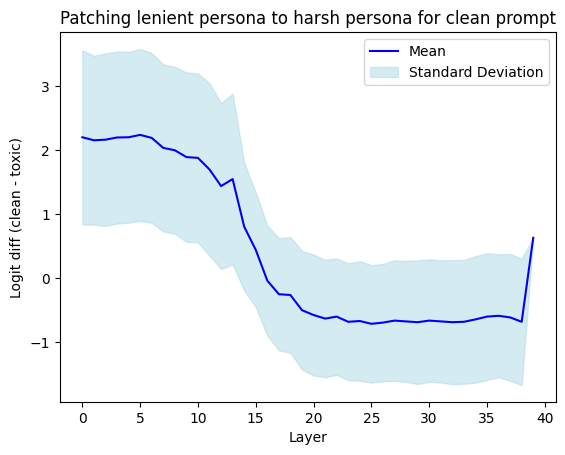

In [32]:
plt.plot(clean_lenient_to_clean_harsh_mean, color='blue', label='Mean')
plt.fill_between(range(len(clean_lenient_to_clean_harsh_mean)), 
                 np.array(clean_lenient_to_clean_harsh_mean) - np.array(clean_lenient_to_clean_harsh_std), 
                 np.array(clean_lenient_to_clean_harsh_mean) + np.array(clean_lenient_to_clean_harsh_std), 
                 color='lightblue', alpha=0.5, label='Standard Deviation')
plt.title("Patching lenient persona to harsh persona for clean prompt")
plt.xlabel("Layer")
plt.ylabel("Logit diff (clean - toxic)")
plt.legend()
plt.show()

In [35]:
simple_patching_results_clean_harsh_to_clean_lenient = []

for toxic_prompt, clean_prompt in prompt_tuples[:10]:
    result = get_input_patching_results_for_prompt_pair(
        model=hooked_model, 
        clean_prompt=clean_prompt, 
        toxic_prompt=toxic_prompt, 
        source_type="clean_harsh",
        target_type="clean_lenient"
    )
    simple_patching_results_clean_harsh_to_clean_lenient.append(result)

clean_harsh_to_clean_lenient_mean = get_means_from_list_of_lists(simple_patching_results_clean_harsh_to_clean_lenient)
clean_harsh_to_clean_lenient_std = get_stds_from_list_of_lists(simple_patching_results_clean_harsh_to_clean_lenient)

100%|██████████| 40/40 [00:09<00:00,  4.43it/s]


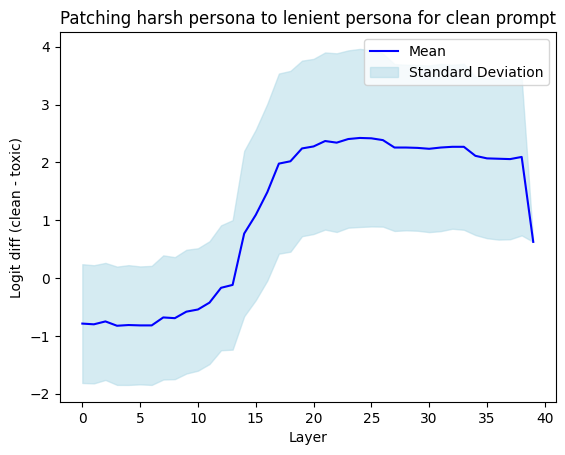

In [36]:
plt.plot(clean_harsh_to_clean_lenient_mean, color='blue', label='Mean')
plt.fill_between(range(len(clean_harsh_to_clean_lenient_mean)), 
                 np.array(clean_harsh_to_clean_lenient_mean) - np.array(clean_harsh_to_clean_lenient_std), 
                 np.array(clean_harsh_to_clean_lenient_mean) + np.array(clean_harsh_to_clean_lenient_std), 
                 color='lightblue', alpha=0.5, label='Standard Deviation')
plt.title("Patching harsh persona to lenient persona for clean prompt")
plt.xlabel("Layer")
plt.ylabel("Logit diff (clean - toxic)")
plt.legend()
plt.show()

In [37]:
simple_patching_results_toxic_harsh_to_clean_harsh = []

for toxic_prompt, clean_prompt in prompt_tuples[:10]:
    result = get_input_patching_results_for_prompt_pair(
        model=hooked_model, 
        clean_prompt=clean_prompt, 
        toxic_prompt=toxic_prompt, 
        source_type="toxic_harsh",
        target_type="clean_harsh"
    )
    simple_patching_results_toxic_harsh_to_clean_harsh.append(result)

toxic_harsh_to_clean_harsh_mean = get_means_from_list_of_lists(simple_patching_results_toxic_harsh_to_clean_harsh)
toxic_harsh_to_clean_harsh_std = get_stds_from_list_of_lists(simple_patching_results_toxic_harsh_to_clean_harsh)

100%|██████████| 40/40 [00:07<00:00,  5.01it/s]


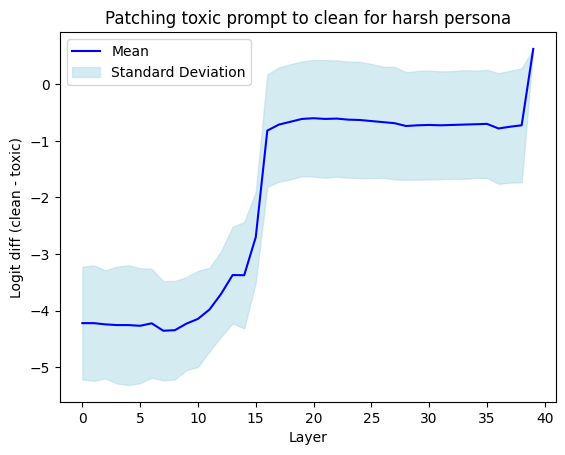

In [38]:
plt.plot(toxic_harsh_to_clean_harsh_mean, color='blue', label='Mean')
plt.fill_between(range(len(toxic_harsh_to_clean_harsh_mean)), 
                 np.array(toxic_harsh_to_clean_harsh_mean) - np.array(toxic_harsh_to_clean_harsh_std), 
                 np.array(toxic_harsh_to_clean_harsh_mean) + np.array(toxic_harsh_to_clean_harsh_std), 
                 color='lightblue', alpha=0.5, label='Standard Deviation')
plt.title("Patching toxic prompt to clean for harsh persona")
plt.xlabel("Layer")
plt.ylabel("Logit diff (clean - toxic)")
plt.legend()
plt.show()